In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from model import model_data, TransformerModel, generate_from_model, validation
from SAE import config_default, TransformerWithSAE

sizes of train, val, test = 1003862, 55778, 55778
vocab size = 66, unique chars:
['\n', ' ', '!', '"', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [3]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Feature manipulation in SAE

In [4]:
class ModifiedModel(TransformerWithSAE):
    def __init__(self, config=config_default, modification=None, SAE=True):
        """
        modification: function x->x or f->f
        SAE: True = modify feature in SAE, False = modify residual stream (skip SAE)
        """
        super().__init__(config=config)
        # freeze all parameters
        for p in self.parameters():
            p.requires_grad = False
        self.modification = modification
        self.SAE = SAE
    @torch.no_grad()
    def normalize_SAE(self):
        """
        normalize SAE such that ||W_dec,i||=1
        """
        W_norm = torch.norm(self.W_dec, dim=-1, keepdim=True)
        self.W_dec.data = self.W_dec/W_norm
        self.W_enc.data = self.W_enc*W_norm
        self.b_enc.data = self.b_enc*W_norm[:,0]
    @torch.no_grad()
    def forward(self, t, y=None):
        """
        returns logits, feature amplitudes, and corss entropy loss
        """
        # run until SAE
        x = self.embed(t)
        x_in = self.layers[:self.layer_for_SAE](x) * self.scale_factor
        if self.SAE:
            features = torch.einsum('...i,ji->...j',x_in,self.W_enc) + self.b_enc
            features = F.relu(features)
            if self.modification is not None:
                features = self.modification(features)
            x_out = torch.einsum('...i,ij->...j',features,self.W_dec) + self.b_dec
        else:
            features = None
            if self.modification is None:
                x_out = x_in
            else:
                x_out = self.modification(x_in)
        # after SAE
        x = self.layers[self.layer_for_SAE:](x_out*(1./self.scale_factor))
        x = self.final_norm(x)
        logits = self.final_lin(x)
        if y is None:
            loss = None
        else:
            loss = F.cross_entropy(logits.view(-1,self.n_token), y.view(-1))
        return logits, features, loss

In [5]:
def new_model(state_dict="SAE_L3.10000.pth"):
    model = ModifiedModel()
    # automatically update location of SAE
    if state_dict[:5] == 'SAE_L':
        model.layer_for_SAE = int(state_dict[5])
    model.to(DEVICE)
    model.load_state_dict(torch.load(state_dict))
    model.update_scale_factor()
    model.normalize_SAE()
    return model

In [6]:
model = new_model()

In [7]:
_ = generate_from_model(model)

his I know,
She is not for your turn, the more my grief.

PETRUCHIO:
I see you do not mean to part with her,
Or else you like not of my company.

BAPTISTA:
Mistake me not; I speak but as I find.
Whence are you, sir? what may I call your name?

PETRUCHIO:
Put likew, eawarl grim rofant ails, let's place are sure.

DUKE VINCENTIO:
SIRDIO:
I'Tis the yields, hear imself, her in him before him,
he's parts prince, favourid men, vale.

DUKE VINCENTIO:
Iignie, the list breath pel,-deged follows!

ESCALUS:
I'll give this bed't you think asks; where is a man aid,
think you that no mothesal pot face, but heas point of her
re-foulll'd bloood of of say of the faires death noble.

DUKE VINCENTIO:
Ay, on poverty to light: most wife, banished!
Did be us singleer of these ted


# Generate some context and predictions

s = context strings

t = predicted char

n = context length

f = feature amplitude

In [7]:
data = model_data.x_test
text = model_data.test
n_blocks = 512 # get test data on this many blocks
n_context_pre = 20
n_context_post = 10
block_size = config_default['n_context']

np.random.seed(42) # fix seed
ix = np.random.choice(range(n_context_pre, len(data) - block_size - n_context_post), (n_blocks,), replace=False)

x = torch.stack([data[i:i+block_size] for i in ix])
y = torch.stack([data[i+1:i+block_size+1] for i in ix])
s = np.array([text[i+j-n_context_pre:i+j+n_context_post+1].replace('\n','↵') for i in ix for j in range(1,block_size+1)])
n = np.array([j for i in ix for j in range(1,block_size+1)])

In [8]:
def run_model(model, fix_seed=True):
    if fix_seed: torch.manual_seed(42)
    logits, features, loss = model(x,y)
    probs = F.softmax(logits, dim=-1).view(-1,logits.shape[-1])
    y_pred = torch.multinomial(probs, num_samples=1)[:,0].cpu().detach().numpy()
    t = np.array([model_data.decode_table[y1].replace('\n','↵') for y1 in y_pred])
    f = features.view(-1,features.shape[-1]).cpu().detach().numpy() if features is not None else None
    return t, f, logits

In [9]:
t, f, _ = run_model(model)

In [10]:
def get_pred_string(s,t,n):
    """
    s: string with length n_context_pre+n_context_post+1
        s[n_context_pre] is the token to be predicted
    t: predicted token
    n: number of token used for prediction
    """
    s_beginning = s[:max(0,n_context_pre-n)]
    s_pre = s[max(0,n_context_pre-n):n_context_pre]
    s_t = s[n_context_pre:n_context_pre+1]
    t_true = s[n_context_pre]
    s_post = s[n_context_pre+1:]
    is_correct = t==t_true
    if not is_correct: s_post = s_post[:-1] # truncate one letter
    NOT_USED = '\033[37m' # Light grey
    PRED = '\033[46m' # cyan bg
    WORNG_PRED = '\033[41m' # red bg
    RESET = '\033[0m'  # Reset to default color
    s_out = NOT_USED+s_beginning+RESET + s_pre + (WORNG_PRED+t+RESET if not is_correct else '') + PRED+t_true+RESET + NOT_USED+s_post+RESET
    return s_out
def inspect_feature_random(feature_id, s, t, n, f, mask=None, n_samples=10, nonzero_only=True):
    is_correct = np.array([s1[n_context_pre]==t1 for s1,t1 in zip(s,t)])
    if mask is None:
        mask = n>-1 # just a all true mask
    if nonzero_only:
        mask = mask & (f[:,feature_id]>0)
    inds = np.random.choice(np.arange(len(s),dtype=int)[mask],n_samples)
    inds = inds[np.argsort(-f[inds,feature_id])]
    print(f'feature L3/{feature_id}')
    for i in inds:
        s_out = get_pred_string(s[i], t[i], n[i]) + f'    f[{feature_id}] = {f[i,feature_id]:.4f}'
        print(s_out)
def inspect_feature_top(feature_id, s, t, n, f, mask=None, n_samples=10):
    score = f[:,feature_id]
    if mask is not None: score[~mask]=0
    inds = np.argsort(-score)[:n_samples]
    print(f'feature L3/{feature_id}')
    for i in inds:
        s_out = get_pred_string(s[i], t[i], n[i]) + f'    f[{feature_id}] = {f[i,feature_id]:.4f}'
        print(s_out)

In [11]:
is_correct = np.array([s_i[n_context_pre]==t_i for s_i,t_i in zip(s,t)])
feature_corr = np.array([np.corrcoef(is_correct, f[:, i])[0, 1] for i in range(f.shape[1])])
I = np.argsort(-feature_corr)
print(I[:10])

/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


[ 316 1790  390   49 1951 1909 1838 1784 1629  522]


In [13]:
inspect_feature_top(316, s,t,n,f)

feature 316
NZALO:↵Ay.↵↵ANTONIO:↵Why, in go    f[316] = 6.4928
hy head.↵↵SEBASTIAN:↵What, art     f[316] = 6.4081
ou, sir.↵↵VINCENTIO:↵You shall     f[316] = 6.2606
↵PROSPERO:↵↵MIRANDA:↵Be of comf    f[316] = 6.2343
, peace.↵↵SEBASTIAN:↵He receive    f[316] = 6.2247
↵PROSPERO:↵↵MIRANDA:↵Be of comf    f[316] = 6.0623
↵PROSPERO:↵↵MIRANDA:↵Be of comf    f[316] = 6.0400
thou hear?↵↵MIRANDA:↵Your tale,    f[316] = 5.9945
 my way!↵↵FERDINAND:↵O, if a vi    f[316] = 5.9557
he moon!↵↵KATHARINA:↵The moon!     f[316] = 5.8578


In [22]:
inspect_feature_top(522, s,t,n,f)

feature 522
n out of her sphere, if she wou    f[522] = 7.7323
re of barren ground, long heath    f[522] = 7.6242
 make me chide thee, if not hat    f[522] = 7.5259
re of barren ground, long heath    f[522] = 7.4010
undred pound or two,↵ to↵make m    f[522] = 7.2650
easure; be't to fly, ↵To swim,     f[522] = 7.1807
ee↵In mine own cell, till thou     f[522] = 7.1660
e↵In this hard rock, whiles you    f[522] = 7.1306
bit; and so may you, sir: and s    f[522] = 7.1184
ee↵In mine own cell, till thou     f[522] = 7.1129


# Find a suitable feature to manipulate

In [13]:
is_correct = np.array([s_i[n_context_pre]==t_i for s_i,t_i in zip(s,t)])
feature_accuracy = np.array([np.mean(is_correct[f[:,i]>0]) for i in range(f.shape[1])])

/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [14]:
feature_frequency = np.mean(f>0, axis=0)

/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


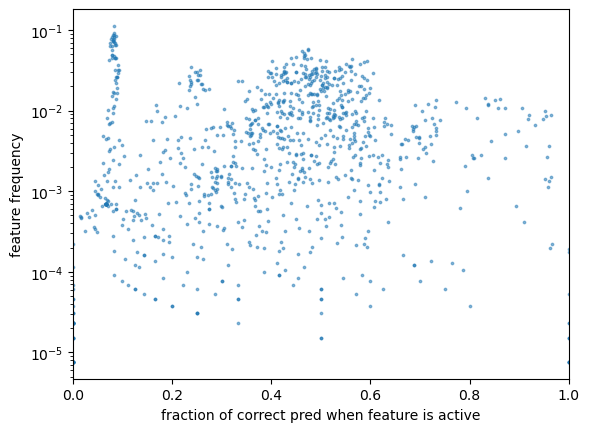

In [15]:
plt.scatter(feature_accuracy, feature_frequency, s=3, alpha=0.5)
plt.xlabel('fraction of correct pred when feature is active')
plt.ylabel('feature frequency')
plt.xlim(0,1)
plt.yscale('log')

In [16]:
I = (feature_accuracy>0.95) & (feature_frequency>1e-3)
print(np.arange(f.shape[-1])[I])

[ 274  316  563  772  904 1790 1825 1951 1962]


In [17]:
# they all do the same: after :, new line if it's a name before, space otherwise
#inspect_feature_random(316, s,t,n,f)

In [18]:
I = (feature_accuracy>0.9) & (feature_accuracy<=0.95) & (feature_frequency>1e-3)
print(np.arange(f.shape[-1])[I])

[  49  508  510 1629 1909 2026]


In [19]:
inspect_feature_random(274, s,t,n,f) 
# 49, 2026: space after ,
# 274: U_, mostly to PETRUCHIO
# 508, 510, 646, 772, 1629: after :
# 563: U_, mostly to PETRUCHIO and LUCENTIO
# 1962: U_, mostly to LUCENTIO and PETRUCHIO

feature 274
er, so it is.↵↵PETRUCHIO:↵Come,    f[274] = 3.6885
ave not seen.↵↵PETRUCHIO:↵What     f[274] = 3.1989
rd were true.↵↵PETRUCHIO:↵Now,     f[274] = 3.1363
 is the moon.↵↵PETRUCHIO:↵Nay,     f[274] = 2.1666
rd were true.↵↵PETRUCHIO:↵Now,     f[274] = 2.0297
ere is Lucentio?↵↵LUCENTIO:↵Her    f[274] = 1.8261
 come to her.↵↵PETRUCHIO:↵Worse    f[274] = 1.2220
rrived at the last↵Upnto the wi    f[274] = 1.2075
d weak and smooth,↵Unapt to toi    f[274] = 0.5414
 never too late.↵↵LUCENTIO:↵At     f[274] = 0.3821


In [20]:
inspect_feature_random(274, s,t,n,f) 
inspect_feature_random(563, s,t,n,f) 
inspect_feature_random(1962, s,t,n,f) 

feature 274
r his master.↵↵PETRUCHIO:↵A goo    f[274] = 4.0473
ng as I live.↵↵PETRUCHIO:↵Nay,     f[274] = 4.0230
 is the moon.↵↵PETRUCHIO:↵Nay,     f[274] = 2.9127
es so bright.↵↵PETRUCHIO:↵Now,     f[274] = 2.8430
me forthwith.↵↵PETRUCHIO:↵O, ho    f[274] = 2.4221
w her answer.↵↵PETRUCHIO:↵What?    f[274] = 2.4180
field is won.↵↵PETRUCHIO:↵Well,    f[274] = 2.2685
 cannot come.↵↵PETRUCHIO:↵How!     f[274] = 2.1378
hither straight.↵↵LUCENTIO:↵Her    f[274] = 1.0814
io hits you now.↵↵LUCENTIO:↵I t    f[274] = 0.7945
feature 563
's my office.↵↵PETRUCHIO:↵Spoke    f[563] = 9.2220
u to the supper.↵↵LUCENTIO:↵And    f[563] = 8.2192
field is won.↵↵PETRUCHIO:↵Well,    f[563] = 7.5538
, love, stay.↵↵PETRUCHIO:↵Is no    f[563] = 6.7578
, love, stay.↵↵PETRUCHIO:↵Is no    f[563] = 6.7578
ior Baptista!↵↵PETRUCHIO:↵Prith    f[563] = 6.7549
igns and tokens.↵↵LUCENTIO:↵I p    f[563] = 6.2498
on; and I will add↵Upnto their     f[563] = 2.4379
l this while.↵↵PETRUCHIO:↵Sir,     f[563] = 1.2801
io hits

# The thou featue from L6 is not in the residual stream yet

In [23]:
# label contexts
def is_thou(s):
    """
    thou or Thou, no more letters before and after
    """
    i = n_context_pre # location of the prediction in context string
    text_match = (s[i-3:i+1]=='thou') or (s[i-3:i+1]=='Thou')
    notext_match = not (s[i-4].isalpha() or s[i+1].isalpha())
    return text_match and notext_match
context_target = np.array([is_thou(s_i) for s_i in s])
print('occurrence of u in thou:',np.mean(context_target))

occurrence of u in thou: 0.00188446044921875


In [24]:
print(f'fraction of characters in "thou": {np.mean(context_target)*4*100:.4f}%')

fraction of characters in "thou": 0.7538%


In [25]:
feature_corr = np.array([np.corrcoef(context_target, f[:, i])[0, 1] for i in range(f.shape[1])])
I = np.argsort(-feature_corr)
print(I[:10])

[1756 1121 1922 1040  376 1412  993  690   70 1577]


In [26]:
for i in range(10):
    if feature_corr[I[i]]<0.1: break
    print(f'feature {I[i]}, correlation {feature_corr[I[i]]:.2f}')
    inspect_feature_random(I[i], s,t,n,f)

feature 1756, correlation 0.18
feature 1756
IO:↵I fly, Biondello.: but they    f[1756] = 1.5280
out sweat or endeavour: treason    f[1756] = 1.0809
re, my art. Wipe thou thine eye    f[1756] = 0.8635
O:↵Hearest thou, Biondello?↵↵BI    f[1756] = 0.7772
amned villain Tranio!,↵That fac    f[1756] = 0.4037
ve into the fire, to ride↵On th    f[1756] = 0.2917
 cheer?↵↵Master:↵Good, speak to    f[1756] = 0.2696
ANCA:↵Fie! what a forolish duty    f[1756] = 0.1029
 and brings your fromward wives    f[1756] = 0.0902
f↵Weigh'd between lovathness an    f[1756] = 0.0802
feature 1121, correlation 0.14
feature 1121
d's sorrow by his wore:↵And now    f[1121] = 2.3888
d is here at the door to speak     f[1121] = 2.0993
nce perfected how to grant suit    f[1121] = 2.0082
ish wench!↵To the morst of men     f[1121] = 1.5637
 confess, hath he not hit you h    f[1121] = 1.0569
w would I give a thousand furlo    f[1121] = 0.6585
, in my rate, she to o,↵Who is     f[1121] = 0.6511
ather.↵↵BAPTISTA:↵How hast t

# Try Petruchio vs Lucentio

In [11]:
# can I maybe try all letters of the word instead?
# say, what correlates most strongly with thou vs not thou

# label contexts
def is_petruchio(s):
    """
    predict C in PETRUCHIO
    """
    i = n_context_pre # location of the prediction in context string
    return s[i-5:i+4] == 'PETRUCHIO'
context_p = np.array([is_petruchio(s_i) for s_i in s])
print('occurrence of C in PETRUCHIO:',np.mean(context_p))

occurrence of C in PETRUCHIO: 0.0009765625


In [12]:
# label contexts
def is_lucentio(s):
    """
    predict C in LUCENTIO
    """
    i = n_context_pre # location of the prediction in context string
    return s[i-2:i+6] == 'LUCENTIO'
context_l = np.array([is_lucentio(s_i) for s_i in s])
print('occurrence of C in LUCENTIO:',np.mean(context_l))

occurrence of C in LUCENTIO: 0.00041961669921875


In [13]:
feature_corr = np.array([np.corrcoef(context_p|context_l, f[:, i])[0, 1] for i in range(f.shape[1])])
I = np.argsort(-feature_corr)
print(I[:10])
print(feature_corr[I[:10]])

/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


[ 772  274 1962  563 1847 1104  464  483 1735  213]
[0.86257287 0.84287749 0.81343022 0.69680126 0.38566536 0.17401675
 0.12919975 0.12842986 0.06892508 0.05767915]


In [15]:
for i in I[:4]:
    inspect_feature_random(i, s,t,n,f) 
# the first 4 are most relevant

feature L3/772
 never too late.↵↵LUCENTIO:↵At     f[772] = 6.6191
of this knavery.↵↵LUCENTIO:↵Loo    f[772] = 6.3989
Who shall begin?↵↵LUCENTIO:↵Tha    f[772] = 4.1509
field is won.↵↵PETRUCHIO:↵Well,    f[772] = 3.7837
shrew of all.↵↵PETRUCHIO:↵Well,    f[772] = 2.6139
d kiss me, Kate.↵↵LUCENTIO:↵Wel    f[772] = 2.5555
 cannot come.↵↵PETRUCHIO:↵How!     f[772] = 1.8939
 are froward.↵↵PETRUCHIO:↵Come,    f[772] = 1.8864
on Petruchio.↵↵PETRUCHIO:↵Padua    f[772] = 1.4723
's my office.↵↵PETRUCHIO:↵Spoke    f[772] = 1.4436
feature L3/274
r his master.↵↵PETRUCHIO:↵A goo    f[274] = 4.0473
ng as I live.↵↵PETRUCHIO:↵Nay,     f[274] = 4.0230
rd were true.↵↵PETRUCHIO:↵Now,     f[274] = 3.1363
 is the moon.↵↵PETRUMCHIO:↵Nay,    f[274] = 2.9127
es so bright.↵↵PETRUCHIO:↵Now,     f[274] = 2.8430
me forthwith.↵↵PETRUCHIO:↵O, ho    f[274] = 2.4221
w her answer.↵↵PETRUCHIO:↵What?    f[274] = 2.4180
field is won.↵↵PETRUCHIO:↵Well,    f[274] = 2.2685
 cannot come.↵↵PETRUCHIO:↵How!     f[274] = 2.1378
i

In [24]:
c = context_p|context_l
c.shape

(131072,)

In [29]:
def plot_fi(fi, label=''):
    active_fraction = np.mean(fi[context_p|context_l]!=0)
    bins = np.linspace(min(0,np.percentile(fi[fi!=0], 1)*1.05),np.percentile(fi[fi!=0], 100)*1.1,20)
    plt.hist(fi[fi!=0], bins=bins, color='silver')
    plt.hist(fi[(context_p|context_l)&(fi!=0)], bins=bins, color='tab:blue')
    plt.hist(fi[context_p&(fi!=0)], bins=bins, color='tab:red')
    #plt.title(f"feature {label}, active {active_fraction*100:.1f}%")
    plt.ylim(0, plt.ylim()[1]*1.1)
    plt.text(0,plt.ylim()[1]*0.95,f"  L3/{label}",fontsize=12,va='top')
    plt.xlabel('feature activation')
    plt.xlim(0, bins[-1])

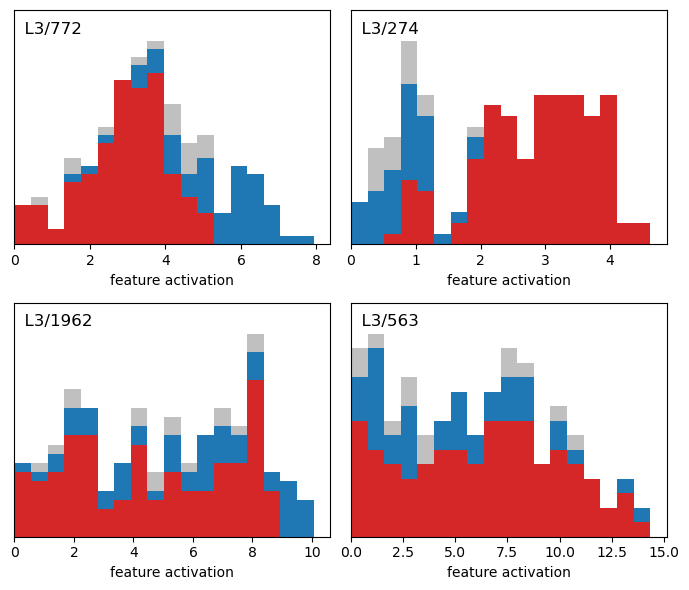

In [31]:
fig, ax = plt.subplots(2,2,figsize=(7,6))
ax = ax.flatten()
for ia,i in enumerate(I[:4]):
    plt.sca(ax[ia])
    plot_fi(f[:,i], i)
    plt.yticks([])
plt.tight_layout()
plt.savefig('figures/L3_activation.png')

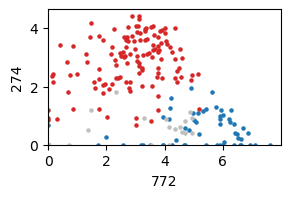

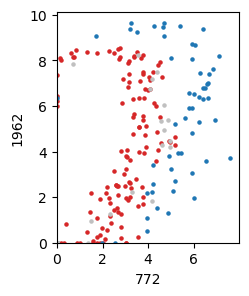

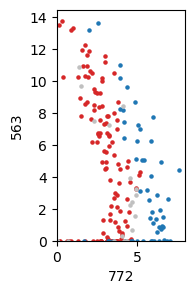

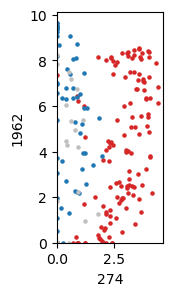

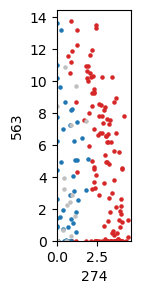

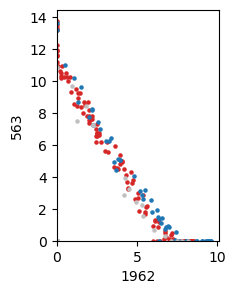

In [18]:
for i in range(4):
    for j in range(i+1,4):
        i1 = I[i]
        i2 = I[j]
        plt.figure(figsize=(3,3))
        plt.scatter(f[:,i1][context_p], f[:,i2][context_p], c='tab:red', s=5)
        plt.scatter(f[:,i1][context_l], f[:,i2][context_l], c='tab:blue', s=5)
        plt.scatter(f[:,i1][~(context_l|context_p)], f[:,i2][~(context_l|context_p)], c='silver', s=5)
        plt.xlabel(f'{i1}')
        plt.ylabel(f'{i2}')
        plt.xlim(0,None)
        plt.ylim(0,None)
        plt.gca().set_aspect('equal')

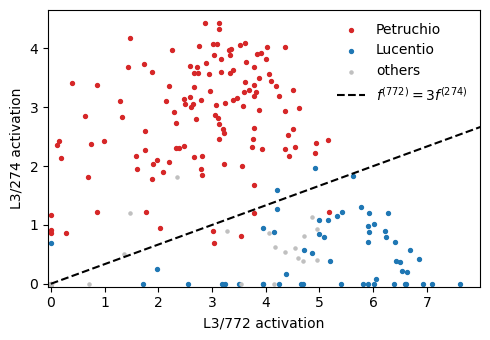

In [34]:
i1 = I[0]
i2 = I[1]
plt.figure(figsize=(5,3.5))
plt.scatter(f[:,i1][context_p], f[:,i2][context_p], c='tab:red', s=8)
plt.scatter(f[:,i1][context_l], f[:,i2][context_l], c='tab:blue', s=8)
plt.scatter(f[:,i1][~(context_l|context_p)], f[:,i2][~(context_l|context_p)], c='silver', s=5)
plt.xlabel(f'L3/{i1} activation')
plt.ylabel(f'L3/{i2} activation')
plt.xlim(-0.05,None)
plt.ylim(-0.05,None)
x0 = np.linspace(0,8)
plt.plot(x0,x0*1/3,'k--')
plt.legend(['Petruchio', 'Lucentio', 'others', r'$f^{(772)}=3f^{(274)}$'], frameon=False)
plt.tight_layout()
plt.savefig('figures/L3_activation_2.png')

In [40]:
i_l = I[0]
i_p = I[1]
i_1 = I[0]
i_2 = I[1]
i_3 = I[2]
i_4 = I[3]
i_5 = I[4]
print(i_p, i_l, i_3, i_4, i_5)

274 772 1962 563 1847


# Visualize model performance

In [38]:
def get_diagnostics(model, return_features=False):
    """
    returns:
    losses on four contexts (all, p, l, other)
    accuracies on four contexts
    predicted chars, correctness
    """
    # make prediction
    t, _, logits = run_model(model)
    n_model = logits.shape[-1]
    logits = logits.view(-1,n_model)
    y_flat = y.view(-1)
    # get loss
    loss = F.cross_entropy(logits,y_flat).item()
    loss_p = F.cross_entropy(logits[context_p,:], y_flat[context_p]).item()
    loss_l = F.cross_entropy(logits[context_l,:], y_flat[context_l]).item()
    loss_o = F.cross_entropy(logits[~(context_p|context_l),:], y_flat[~(context_p|context_l)]).item()
    # is prediction correct?
    c = np.array([s_i[n_context_pre]==t_i for s_i,t_i in zip(s,t)])
    # accuracy on contexts
    acc = np.mean(c)
    acc_p = np.mean(c[context_p])
    acc_l = np.mean(c[context_l])
    acc_o = np.mean(c[~(context_p|context_l)])
    return loss, loss_p, loss_l, loss_o, acc, acc_p, acc_l, acc_o, t, c

In [50]:
# percentage change in loss
def summarize_change(x, models, ax=None):
    """
    two panels: accuracy and loss
    """
    if ax is None: fig, ax = plt.subplots(1,2,figsize=(7,3.5))
    c_a = c_o = 'grey'
    c_p = 'tab:red'
    c_l = 'tab:blue'
    plt.sca(ax[1])
    plt.plot(x, [m[0] for m in models], color=c_a, label='all')
    plt.plot(x, [m[1] for m in models], color=c_p, lw=2, marker='.', label='Petruchio')
    plt.plot(x, [m[2] for m in models], color=c_l, lw=2, marker='.', label='Lucentio')
    #plt.plot(x, [m[3] for m in models], color=c_o, ls=':', label='others')
    plt.ylim(0,None)
    plt.xlim(x[0],x[-1])
    plt.ylabel('cross-entropy loss')
    plt.xlabel(r'$\delta$')
    plt.title(' ')
    plt.sca(ax[0])
    plt.plot(x, [m[4] for m in models], color=c_a, label='all')
    plt.plot(x, [m[5] for m in models], color=c_p, lw=2, marker='.', label='Petruchio')
    plt.plot(x, [m[6] for m in models], color=c_l, lw=2, marker='.', label='Lucentio')
    #plt.plot(x, [m[7] for m in models], color=c_o, ls=':', label='others')
    plt.ylabel('accuracy')
    plt.xlabel(r'$\delta$')
    plt.ylim(0,1)
    plt.xlim(x[0],x[-1])
    plt.legend(frameon=False)
    plt.title(' ')
    plt.tight_layout()
    return ax

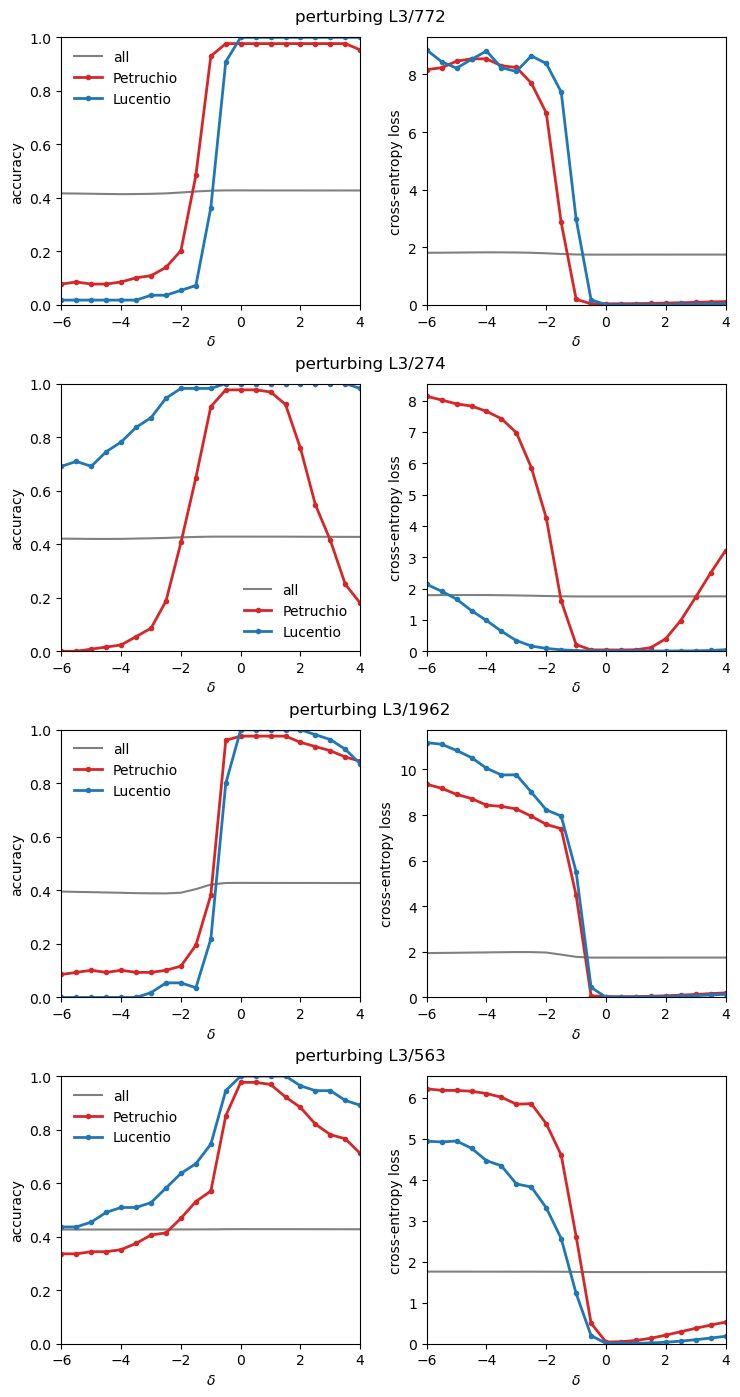

In [57]:
"""
linear perturbation, SAE
"""
fig, ax = plt.subplots(4,2,figsize=(7.5,3.5*4))

for i in range(4):
    models = {}
    models['deltas'] = np.linspace(-6,4,21)
    models['models'] = []
    
    delta = 0
    def modification(f):
        f[..., I[i]] = f[..., I[i]]*(1+delta)
        return f

    model = new_model()
    model.modification = modification

    for d in models['deltas']:
        delta = d
        models['models'].append(get_diagnostics(model))
    
    summarize_change(models['deltas'], models['models'], ax=ax[i])
    
    eps = 0.005
    fig.text(0.5, eps+(1-2*eps)*(1-i*0.25), f'perturbing L3/{I[i]}', fontsize=12, ha='center', va='top')

#plt.savefig('figures/L3_SAE.png')

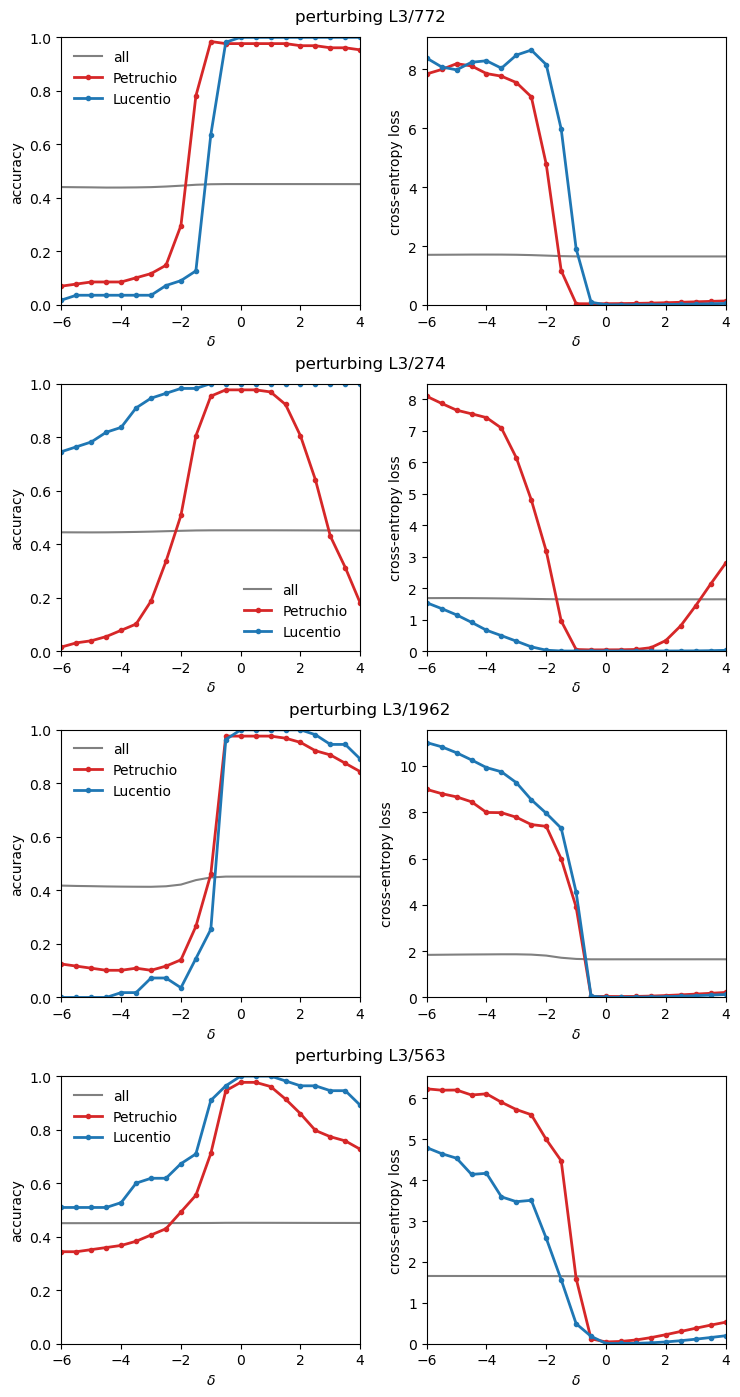

In [58]:
"""
linear perturbation, in-place
"""
fig, ax = plt.subplots(4,2,figsize=(7.5,3.5*4))

for i in range(4):
    models = {}
    models['deltas'] = np.linspace(-6,4,21)
    models['models'] = []
    
    delta = 0
    def modification(x):
        f = torch.sum(x*model.W_enc[I[i]], dim=-1) + model.b_enc[I[i]]
        f = F.relu(f)
        x = x + delta*f.unsqueeze(-1)*model.W_dec[I[i]]
        return x

    model = new_model()
    model.SAE = False
    model.modification = modification

    for d in models['deltas']:
        delta = d
        models['models'].append(get_diagnostics(model))
    
    summarize_change(models['deltas'], models['models'], ax=ax[i])

    eps = 0.005
    fig.text(0.5, eps+(1-2*eps)*(1-i*0.25), f'perturbing L3/{I[i]}', fontsize=12, ha='center', va='top')

#plt.savefig('figures/L3_inplace.png')

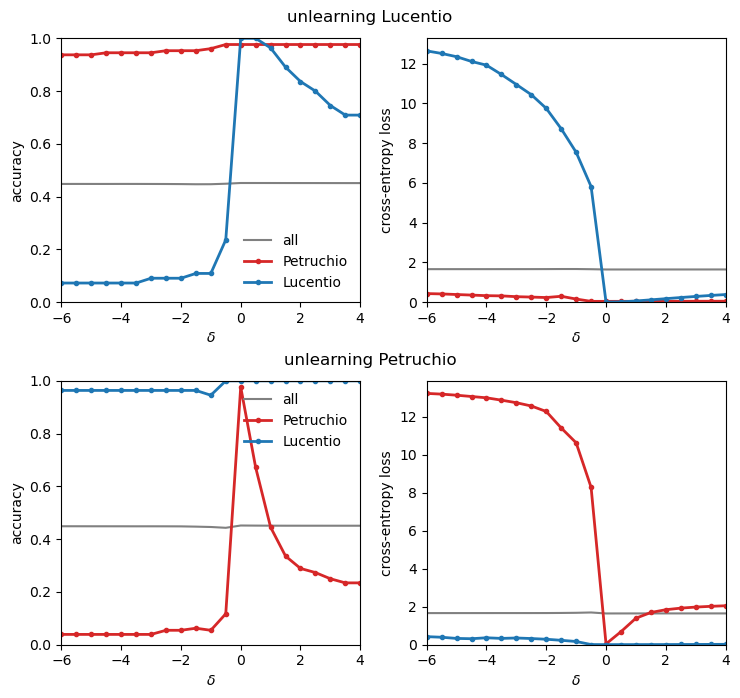

In [72]:
"""
linear perturbation, in-place
"""
fig, ax = plt.subplots(2,2,figsize=(7.5,3.5*2))

for i in range(2):
    models = {}
    models['deltas'] = np.linspace(-6,4,21)
    models['models'] = []
    
    model = new_model()
    model.SAE = False
    
    delta = 0
    sign = 1 if i==0 else -1
    def modification(x):
        f772 = F.relu(torch.sum(x*model.W_enc[772], dim=-1) + model.b_enc[772])
        f274 = F.relu(torch.sum(x*model.W_enc[274], dim=-1) + model.b_enc[274])
        xi = F.relu(sign*(f772-f274*3))
        x = x + delta*(xi*f772).unsqueeze(-1)*model.W_dec[772] + delta*(xi*f274).unsqueeze(-1)*model.W_dec[274]
        return x

    model.modification = modification

    for d in models['deltas']:
        delta = d
        models['models'].append(get_diagnostics(model))
    
    summarize_change(models['deltas'], models['models'], ax=ax[i])

    eps = 0.01
    name = 'Lucentio' if i==0 else 'Petruchio'
    fig.text(0.5, eps+(1-2*eps)*(1-i*0.5), f'unlearning {name}', fontsize=12, ha='center', va='top')

plt.savefig('figures/L3_inplace_mix.png')